In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import tensorflow as tf
import cv2

import sklearn
import scipy.stats as stats
import scipy.special as sps
from tqdm.notebook import tqdm

import os
import time
from glob import glob
import random
import re

print(f'tensorflow version: {tf.__version__}')
print(f'opencv version:     {cv2.__version__}')
#tf.config.run_functions_eagerly(True) # for debugging

tensorflow version: 2.5.0
opencv version:     4.5.2


## NEON Still-frame Convolutional Autoencoder with Grad-CAM Attention

In this notebook, we will compile and train a convolutional autoencoder which we will use to detect anomalies in still-frame images. 

Our hypothesis is that the autoencoder's reconstruction loss of a still-frame image will be higher for anomalous images than for normal images. We will also impose as a kind of regularization mechanism that the attention (estimated by the Jacobian of the network at the final convolutional layer of the encoder) be distributed uniformly within all "normal" images. The paper that proposed the use of this attention mechanism can be found here:

[https://arxiv.org/abs/1911.08616](https://arxiv.org/abs/1911.08616)

### Dataset
---
The dataset used in this notebook is taken from the NEON phenocam data repository. You can browse the data repository via NEON's Data Portal at [https://data.neonscience.org/](https://data.neonscience.org/).

A useful tool for downloading and formatting the data directory can be found at: [https://github.com/waggle-sensor/ml-neon-snow](https://github.com/waggle-sensor/ml-neon-snow).

Since I was not able to find anomalous images in the NEON dataset,
I resorted to inserting 'fake' anomalies in the dataset using photo editing software. You can download the contents of the 'anomalies' directory that I used for some selected NEON sites at the link below:

[https://drive.google.com/file/d/1EiSFWRxLM6VmST3oGDl-8L432V6tFTQp/view?usp=sharing](https://drive.google.com/file/d/1EiSFWRxLM6VmST3oGDl-8L432V6tFTQp/view?usp=sharing)

In [2]:
from tensorflow.keras.utils import Sequence

class NEONDatasetBatcher(Sequence):
    """
        This class loads NEON images in batches
    """
    
    def __init__(self, image_paths, batch_size, image_shape):
        
        assert(image_shape[0] > 0)
        assert(image_shape[1] > 0)
        assert(image_shape[2] == 3)
        self.image_shape = image_shape
        self.image_paths = image_paths
        self.batch_size = batch_size
        
    def __len__(self):
        return (np.ceil(len(self.image_paths) / float(self.batch_size))).astype(np.int)
    
    def full_batch_len(self):
        return len(self.image_paths) // self.batch_size
    
    def __getitem__(self, idx):
        batch_paths = self.image_paths[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_images = []
        for path in batch_paths:
            im = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, (self.image_shape[0],self.image_shape[1]))
            batch_images.append(im)
            batch_np = (np.array(batch_images, dtype=np.float32) / 255.)
        return batch_np, batch_np
    
class NEONDataset():
    """
        This class loads a NEON dataset. The directory structure is:
         <path>
            |--- normal
            |      |--- <NEON_SITE>
            |      |       |--- <yyyy>
            |      |       |      |--- <mm>
            |      |       |      |     | --- <image0.jpg>
            |      |       |      |     | --- <image1.jpg>
            |     ...     ...    ...   ...
            |
            |--- anomalies
            |      |--- <NEON_SITE>
            |      |       |--- <yyyy>
            |      |       |      |--- <mm>
            |      |       |      |     | --- <imageA.jpg>
            |      |       |      |     | --- <imageB.jpg>
            |     ...     ...    ...   ...
    """
    
    def __init__(self, path):
        assert(os.path.isdir(path))
        self.path = path
        self.normal_site_data = {}
        self.anomalies_site_data = {}
        subdirs = os.listdir(path)
        assert('normal' in subdirs)
        assert('anomalies' in subdirs)
        normal_path = os.path.join(path, 'normal')
        anomalies_path = os.path.join(path, 'anomalies')
        
        # parse normal data:
        self.sites = list(set(os.listdir(normal_path)) | set(os.listdir(anomalies_path)))
        for site_name in self.sites:
            site_path = os.path.join(normal_path, site_name)
            site_images = [
                y for x in os.walk(site_path) \
                    for y in glob(os.path.join(x[0], '*.jpg'))
            ]
            self.normal_site_data[site_name] = site_images
            
        # parse anomalous site data:
        for site_name in self.sites:
            site_path = os.path.join(anomalies_path, site_name)
            site_images = [
                y for x in os.walk(site_path) \
                    for y in glob(os.path.join(x[0], '*.jpg'))
            ]
            self.anomalies_site_data[site_name] = site_images

    def load_img(self, img_path):
        img = cv2.imread(img_path)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    def get_normal_batchers(self, site_name, image_shape=(1280, 960, 3), 
                            batch_size=4, test_holdout=0.2, shuffle=True):
        image_paths = self.normal_site_data[site_name].copy()
        if shuffle:
            random.shuffle(image_paths)
        holdout_ind = int(test_holdout*len(image_paths))
        test_images = image_paths[:holdout_ind]
        train_images = image_paths[holdout_ind:]
        test_batcher = NEONDatasetBatcher(test_images, batch_size, image_shape)
        train_batcher = NEONDatasetBatcher(train_images, batch_size, image_shape)
        return train_batcher, test_batcher
        
    def get_anomalies_batcher(self, site_name, image_shape=(1280, 960, 3), batch_size=1):
        return NEONDatasetBatcher(self.anomalies_site_data[site_name], batch_size, image_shape)
        
    

Examples from NEON.D10.RMNP.DP1.00033:
(there are 2011 normal images for this site).


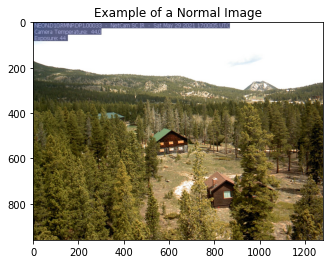

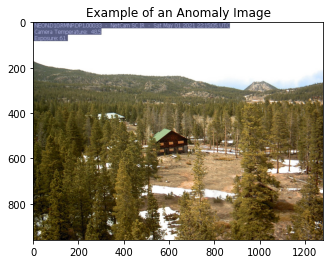

In [3]:
neon = NEONDataset('/datasets/neon')

site_of_interest = 'NEON.D10.RMNP.DP1.00033'
train_batcher, test_batcher = neon.get_normal_batchers(site_of_interest)
anomaly_batcher = neon.get_anomalies_batcher(site_of_interest)
example_normal_img = test_batcher.__getitem__(0)[0][0,...]
example_anomaly_img = anomaly_batcher.__getitem__(0)[0][0,...]

print(f'Examples from {site_of_interest}:')
print(f'(there are {len(neon.normal_site_data[site_of_interest])} normal images for this site).')
plt.imshow(example_normal_img)
plt.title('Example of a Normal Image')
plt.show()

plt.imshow(example_anomaly_img)
plt.title('Example of an Anomaly Image')
plt.show()

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.regularizers import l2

class NEON_Attention_CAE(Model):
    
    LAST_ENCODER_CONV_NAME = 'last_encoder_conv'
    
    def __init__(self, latent_dim=64, input_shape=(960,1280,3), 
                 attention_weight=0.05):
        super(NEON_Attention_CAE, self).__init__()
        
        # The number of encoding features
        self.latent_dim = latent_dim
        
        # weight for attention regularization:
        self.attention_weight = attention_weight
        
        # encoder leaky ReLU
        lrelu = layers.LeakyReLU(alpha=0.1)
        
        # encoder regularizer
        reg = l2(5e-4)
        
        # Encoder Layers:
        self.conv_encoder = tf.keras.Sequential([
            # apply 7x7 filter with maxpooling:
            layers.Conv2D(filters=16, kernel_size= (11, 11), 
                            strides=(2, 2), input_shape =input_shape, 
                            padding = 'same', activation=layers.LeakyReLU(alpha=0.1), 
                            kernel_regularizer=reg),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'),
            
            # apply 3x3 filter with maxpooling:
            layers.Conv2D(filters=32, kernel_size= (3, 3), 
                            padding = 'same', activation=lrelu, 
                            kernel_regularizer=reg),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'),
            
            # apply 3x3, 1x1 filter with maxpooling:
            layers.Conv2D(filters=48, kernel_size= (1, 1), 
                            padding = 'same', activation=lrelu, 
                            kernel_regularizer=reg),
            layers.Conv2D(filters=48, kernel_size= (3, 3), 
                            padding = 'same', activation=lrelu, 
                            kernel_regularizer=reg),
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'),
            
            # apply 3x3, 1x1 filter (do maxpooling in the latent encoder):
            layers.Conv2D(filters=64, kernel_size= (1, 1), 
                            padding = 'same', activation=lrelu, 
                            kernel_regularizer=reg),
            layers.Conv2D(filters=64, kernel_size= (3, 3), 
                            padding = 'same', activation=lrelu, 
                            kernel_regularizer=reg, name='last_conv_layer'),
        ],name='conv_encoder')
        
        self.last_conv_output_shape = tuple(x for x in self.conv_encoder.layers[-1].output_shape if x != None)
        self.latent_encoder = tf.keras.Sequential([
            # pool output from last conv layer:
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same',
                                input_shape=self.last_conv_output_shape),
            
            # add dense latent layer:
            layers.Flatten(),
            layers.Dense(latent_dim)
        ], name='latent_encoder')
        
        # Decoder Layers:
        last_maxpool_output_shape = tuple( x for x in self.latent_encoder.layers[-2].input_shape if x != None )
        last_maxpool_output_size = np.prod(last_maxpool_output_shape)
        self.decoder = tf.keras.Sequential([
            # reshape back to last conv layer output:
            layers.Dense(last_maxpool_output_size, input_shape=(latent_dim,)),
            layers.Reshape(last_maxpool_output_shape),
            
            # apply upsampling, then transposed 1x1 and 2x2 filter (no regularizer):
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2DTranspose(filters=64, kernel_size=(3,3),
                                      padding='same', activation=lrelu),
            layers.Conv2DTranspose(filters=64, kernel_size=(1,1),
                                      padding='same', activation=lrelu),
            
            # apply upsampling, then transposed 1x1 and 2x2 filter (no regularizer):
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2DTranspose(filters=48, kernel_size=(3,3),
                                      padding='same', activation=lrelu),
            layers.Conv2DTranspose(filters=48, kernel_size=(1,1),
                                      padding='same', activation=lrelu),
            
            # apply upsampling, then transposed 3x3 filter (no regularizer):
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2DTranspose(filters=32, kernel_size=(3,3),
                                      padding='same', activation=lrelu),
            
            # apply upsampling, then transposed 11x11 filter (no regularizer):
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2DTranspose(filters=16, kernel_size=(11,11), strides=(2, 2),
                                      padding='same', activation=lrelu),
            layers.Conv2D(filters=3, kernel_size=(1,1), padding='same', activation='sigmoid')
        ], name='decoder')
    
    
    def compute_loss(self, x):
        x_pred, attention_map = self.call_with_attention(x)
        loss = tf.reduce_mean(tf.square(x_pred - x))
        ae_loss = tf.reduce_mean(1.0 - attention_map)
        
        return loss + self.attention_weight*ae_loss
        
    def call_with_attention(self, x):
        conv_output = self.conv_encoder(x)
        with tf.GradientTape() as tape:
            tape.watch(conv_output)
            z = self.latent_encoder(conv_output)
            grads = tape.gradient(z, conv_output)
            
        # compute the attention map by multiplying the convolutional 
        # layer output by the pooled gradients and taking the positive 
        # component of the summation over all channels 
        # (this is the Grad-CAM algorithm)
        pooled_grads = tf.reduce_mean(grads, axis=[1,2], keepdims=True)
        attention_channels = tf.multiply(pooled_grads, conv_output)
        attention_map = tf.nn.relu(tf.reduce_mean(attention_channels, axis=-1))
        
        decoded = self.decoder(z)
        return decoded, attention_map
    
    def call(self, x):
        z = self.latent_encoder(self.conv_encoder(x))
        return self.decoder(z)
    
    @tf.function
    def train_step(self, x, optimizer):
        """Executes a single training step"""
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
            gradients = tape.gradient(loss, self.trainable_variables)
            optimizer.apply_gradients(
                zip(gradients, self.trainable_variables))
            return loss

cae = NEON_Attention_CAE(latent_dim=64)
cae.conv_encoder.summary()
cae.latent_encoder.summary()
cae.decoder.summary()

Model: "conv_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 480, 640, 16)      5824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 240, 320, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 320, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 160, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 48)      1584      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 160, 48)      20784     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 80, 48)       

In [5]:
n_epochs = 40
optimizer = tf.keras.optimizers.Adam(1e-3)
train_loss_history = []
test_loss_history = []

for i in range(n_epochs):
    start_time = time.time()
    loss = tf.keras.metrics.Mean()
    for train_batch in tqdm(train_batcher):
        loss(cae.train_step(train_batch[0], optimizer))
    train_loss = loss.result()
    train_loss_history.append(train_loss)
    end_time = time.time()
    
    loss = tf.keras.metrics.Mean()
    for test_batch in test_batcher:
        loss(cae.compute_loss(test_batch[0]))
    loss = loss.result()
    test_loss_history.append(loss)
    time_delta = end_time - start_time
    print(f'Epoch {i+1} ({time_delta:.2f} s)')
    print(f'Train loss: {train_loss:.8f} | Test loss: {loss:.8f}')


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 1 (134.48 s)
Train loss: 0.02955066 | Test loss: 0.02179161


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 2 (130.16 s)
Train loss: 0.01989056 | Test loss: 0.01867799


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 3 (130.41 s)
Train loss: 0.01868144 | Test loss: 0.01799058


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 4 (130.26 s)
Train loss: 0.01753069 | Test loss: 0.01715030


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 5 (130.63 s)
Train loss: 0.01709541 | Test loss: 0.01675007


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 6 (130.52 s)
Train loss: 0.01685123 | Test loss: 0.01634433


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 7 (130.49 s)
Train loss: 0.01691215 | Test loss: 0.01692074


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 8 (130.38 s)
Train loss: 0.01637690 | Test loss: 0.01597316


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 9 (130.61 s)
Train loss: 0.01596375 | Test loss: 0.01555739


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 10 (130.28 s)
Train loss: 0.01590624 | Test loss: 0.01549157


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 11 (130.55 s)
Train loss: 0.01563946 | Test loss: 0.01558534


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 12 (130.60 s)
Train loss: 0.01552629 | Test loss: 0.01534692


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 13 (130.58 s)
Train loss: 0.01538882 | Test loss: 0.01538512


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 14 (130.51 s)
Train loss: 0.01534084 | Test loss: 0.01519053


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 15 (130.60 s)
Train loss: 0.01511940 | Test loss: 0.01514672


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 16 (130.39 s)
Train loss: 0.01498761 | Test loss: 0.01496122


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 17 (130.71 s)
Train loss: 0.01527218 | Test loss: 0.01567920


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 18 (130.47 s)
Train loss: 0.01509554 | Test loss: 0.01509472


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 19 (130.80 s)
Train loss: 0.01484052 | Test loss: 0.01478409


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 20 (130.84 s)
Train loss: 0.01474098 | Test loss: 0.01487667


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 21 (130.71 s)
Train loss: 0.01456591 | Test loss: 0.01462053


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 22 (130.86 s)
Train loss: 0.01455816 | Test loss: 0.01488372


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 23 (130.65 s)
Train loss: 0.01462718 | Test loss: 0.01464433


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 24 (130.39 s)
Train loss: 0.01447774 | Test loss: 0.01469791


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 25 (131.01 s)
Train loss: 0.01436882 | Test loss: 0.01473436


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 26 (130.62 s)
Train loss: 0.01436506 | Test loss: 0.01483359


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 27 (130.60 s)
Train loss: 0.01445451 | Test loss: 0.01462209


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 28 (130.68 s)
Train loss: 0.01432440 | Test loss: 0.01447813


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 29 (130.49 s)
Train loss: 0.01428157 | Test loss: 0.01459220


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 30 (130.81 s)
Train loss: 0.01420446 | Test loss: 0.01448275


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 31 (130.34 s)
Train loss: 0.01414740 | Test loss: 0.01449386


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 32 (130.41 s)
Train loss: 0.01415093 | Test loss: 0.01470846


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 33 (130.66 s)
Train loss: 0.01414166 | Test loss: 0.01446476


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 34 (131.18 s)
Train loss: 0.01407146 | Test loss: 0.01472769


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 35 (130.44 s)
Train loss: 0.01414651 | Test loss: 0.01458362


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 36 (130.71 s)
Train loss: 0.01405240 | Test loss: 0.01462401


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 37 (130.47 s)
Train loss: 0.01398832 | Test loss: 0.01431724


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 38 (130.51 s)
Train loss: 0.01392217 | Test loss: 0.01429684


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 39 (130.60 s)
Train loss: 0.01390744 | Test loss: 0.01426499


  0%|          | 0/403 [00:00<?, ?it/s]

Epoch 40 (130.69 s)
Train loss: 0.01387202 | Test loss: 0.01442212


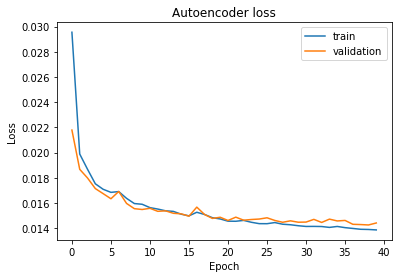

In [6]:
plt.plot(np.array(train_loss_history))
plt.plot(np.array(test_loss_history))
plt.title('Autoencoder loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.show()

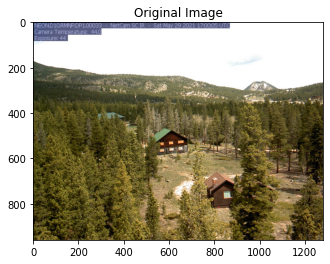

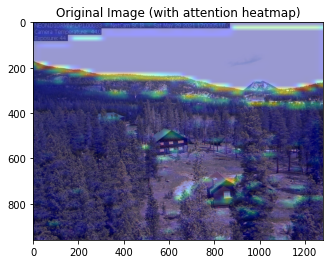

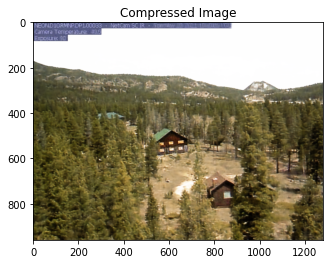

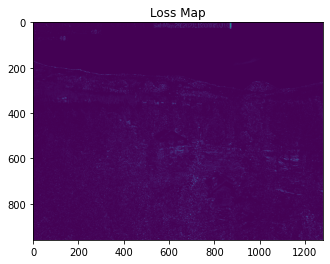

In [7]:
def overlay_attention_map(img, attention_map, scale=True, mix=0.4, cmap='jet'):
    jet = matplotlib.cm.get_cmap(cmap)
    jet_colors = jet(np.arange(256))[:,:3]
    att_min, att_max = np.min(attention_map), np.max(attention_map)
    
    if scale:
        attention_map = (attention_map - att_min) / (att_max - att_min)
    
    heatmap = np.uint8(255 * np.clip(attention_map, 0, 1))
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = cv2.resize(jet_heatmap, (img.shape[-2],img.shape[-3]), cv2.INTER_NEAREST)
    
    overlay_img = np.clip((jet_heatmap*mix + img*(1-mix)),0,1)
    return overlay_img
    
# plot validation example:
val_example = test_batcher.__getitem__(0)[0][0:1,...]

plt.figure()
plt.imshow(val_example[0])
plt.title('Original Image')
plt.show()

compressed_example, attention_map = cae.call_with_attention(val_example)
attention_example = overlay_attention_map(
                        val_example[0], np.squeeze(attention_map))

plt.figure()
plt.imshow(attention_example)
plt.title('Original Image (with attention heatmap)')
plt.show()

plt.figure()
plt.imshow(compressed_example[0])
plt.title('Compressed Image')
plt.show()

lossmap = np.sum((val_example - compressed_example)**2, axis=3)
plt.figure()
plt.imshow(lossmap[0])
plt.title('Loss Map')
plt.show()




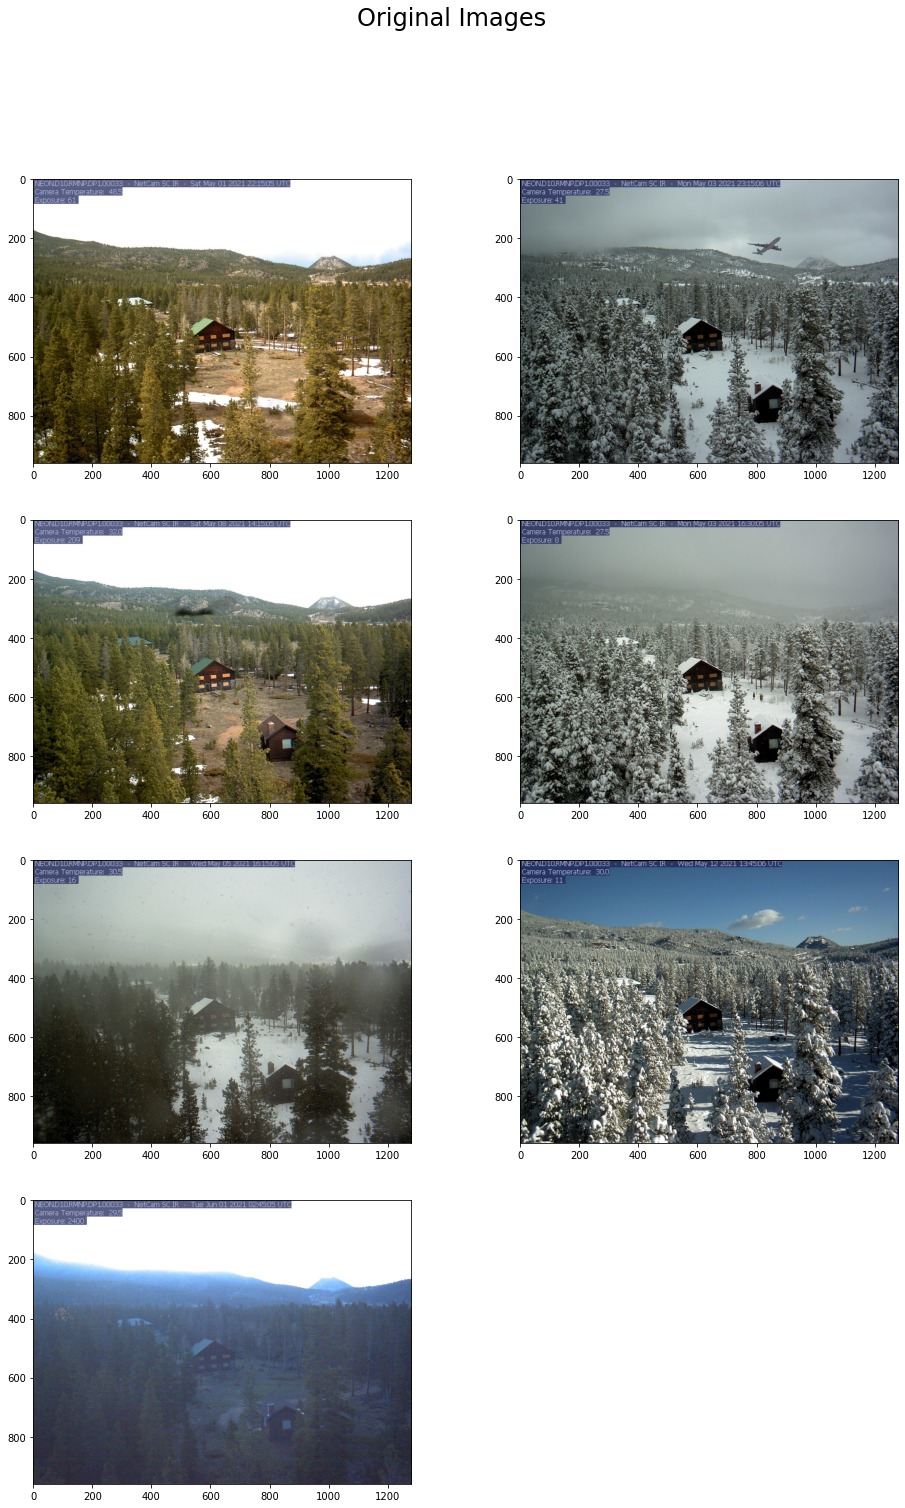

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


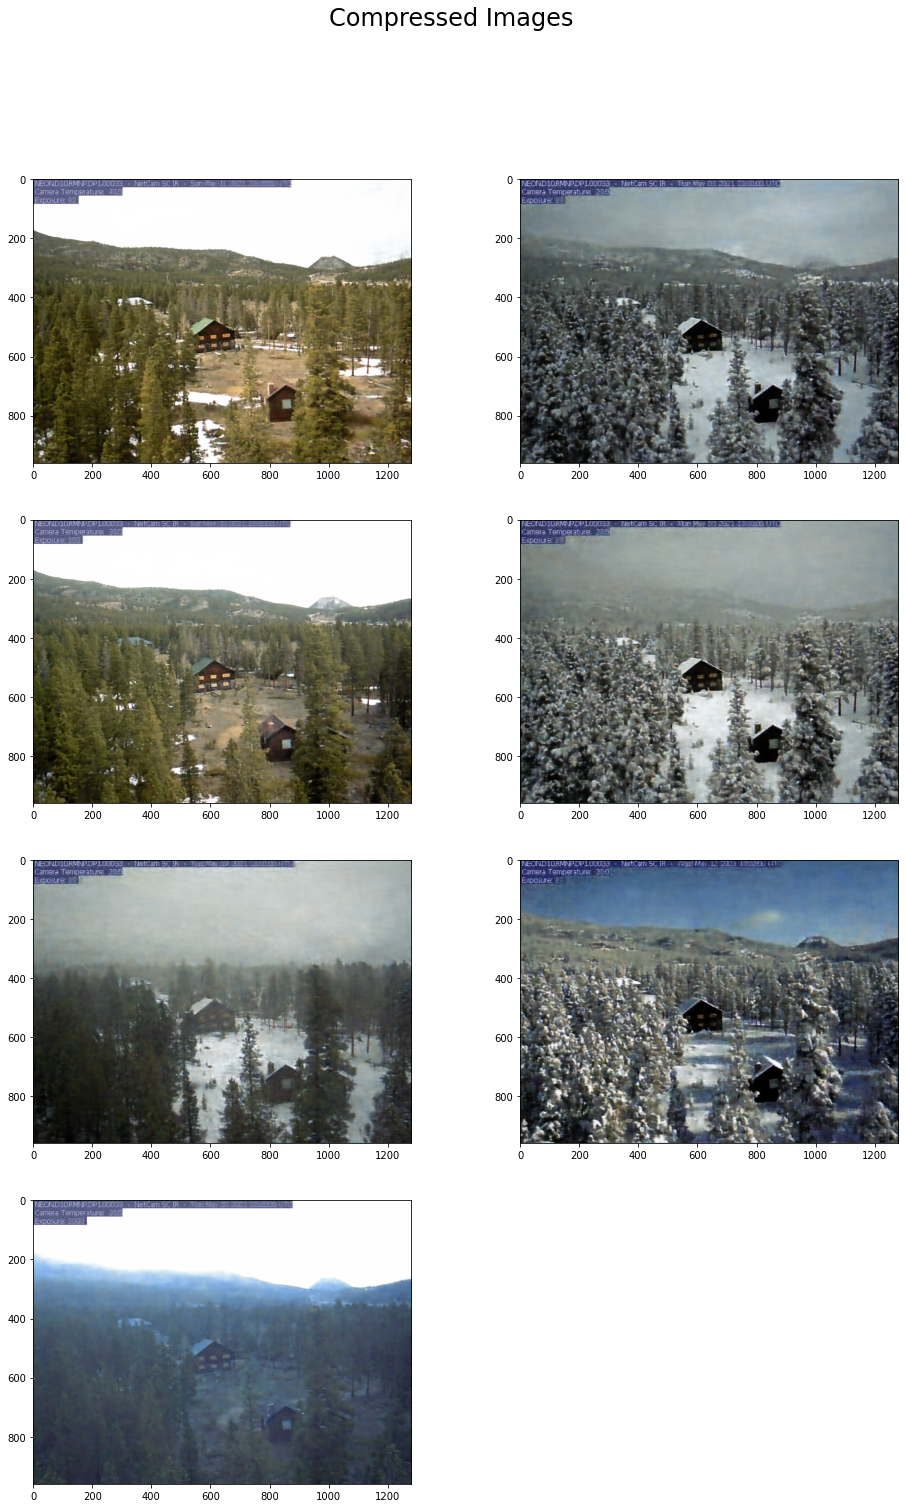

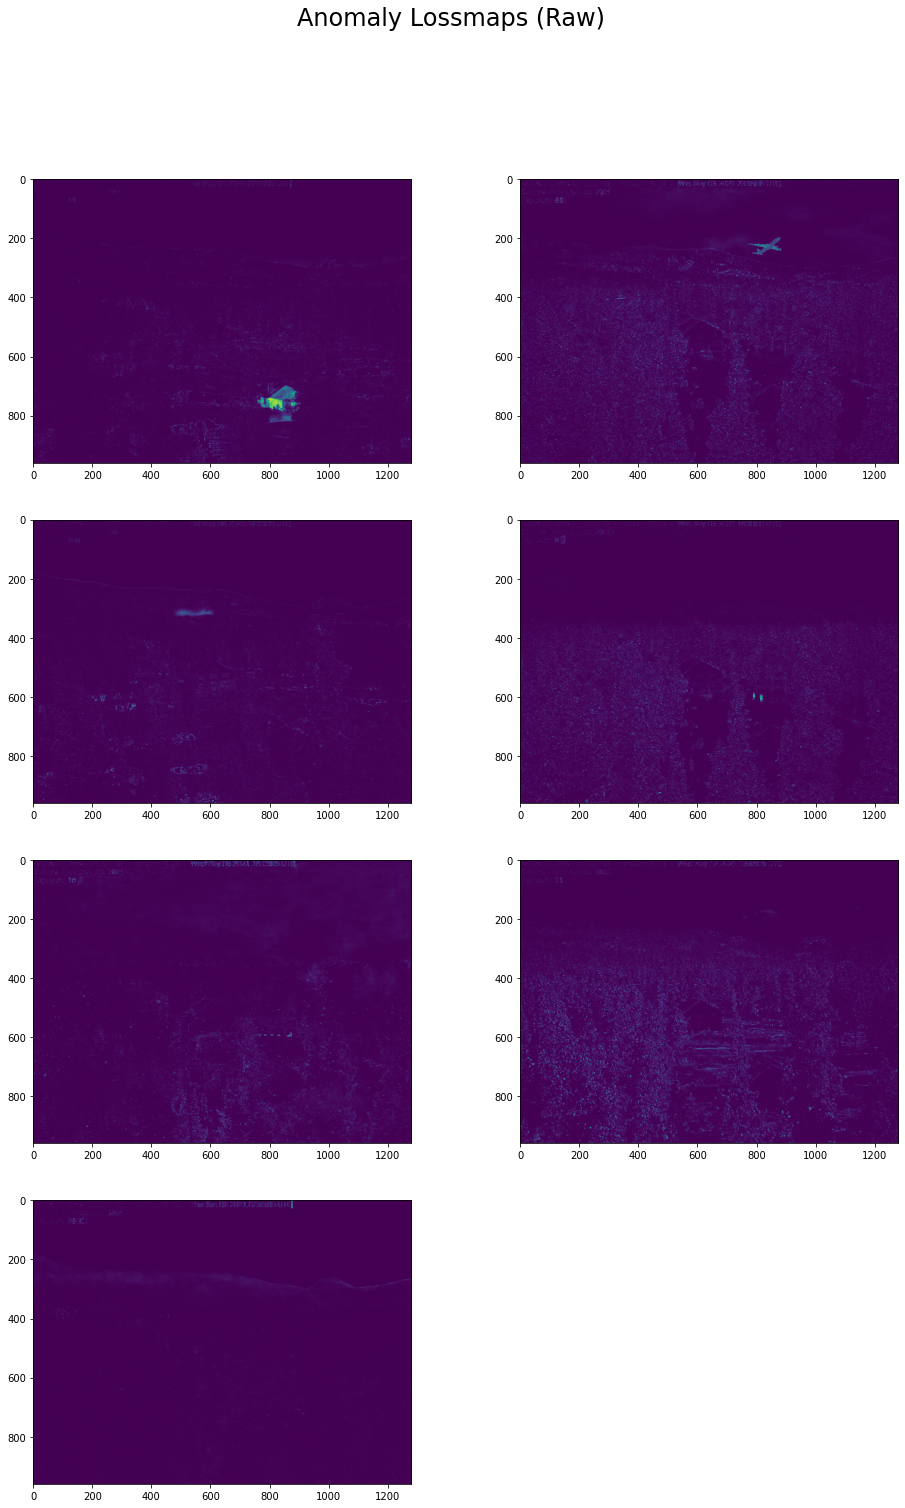

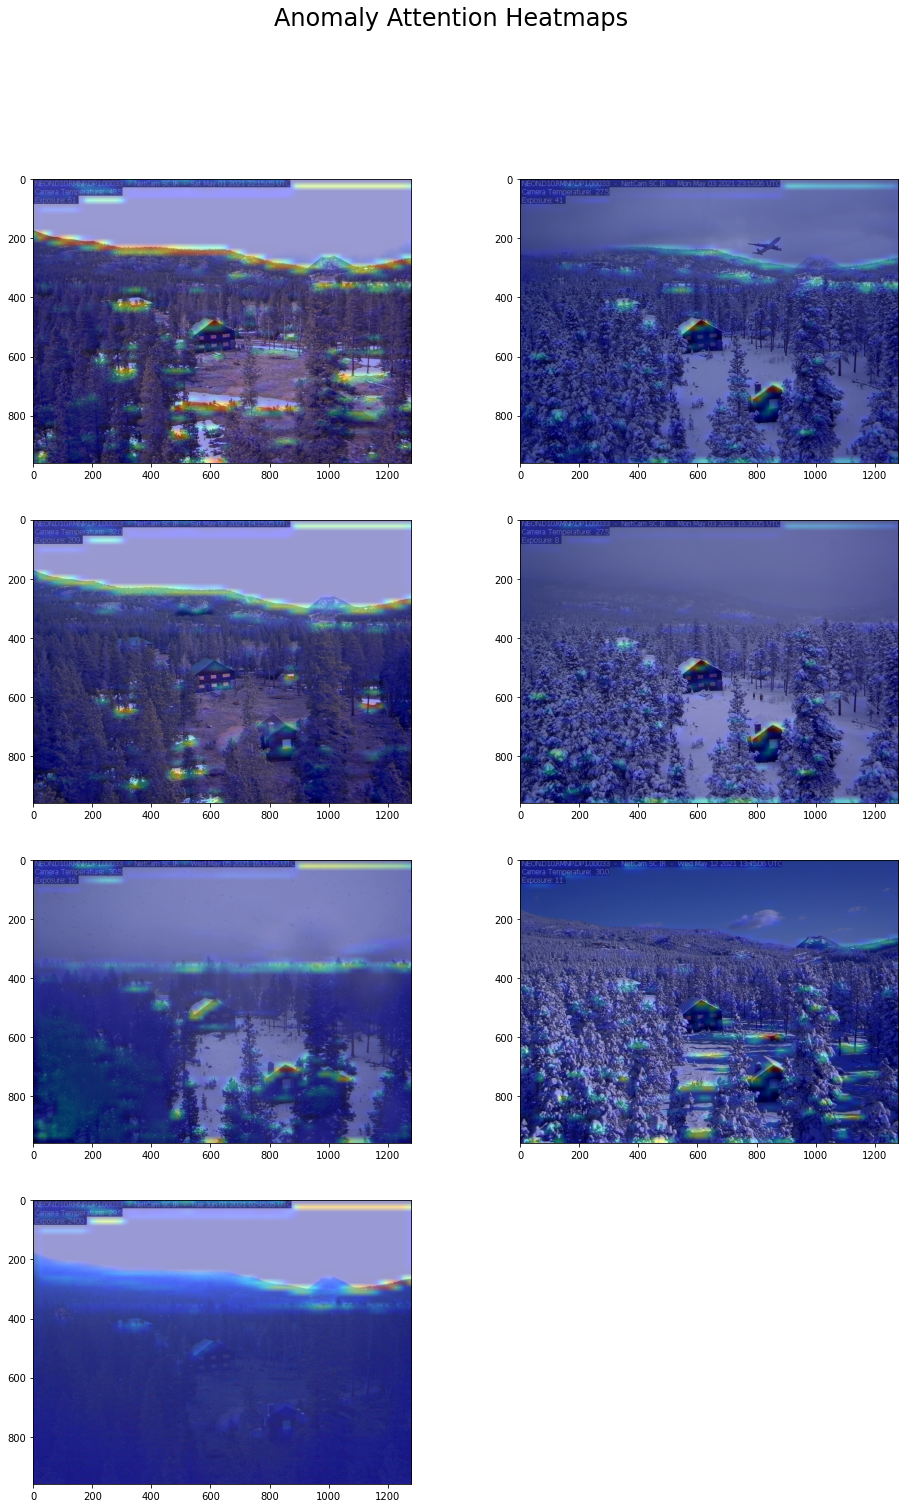

In [8]:
# plot anomaly example:
n_anomalies = len(anomaly_batcher)
anomaly_examples = [
    anomaly_batcher.__getitem__(i)[0][0:1,...]
    for i in range(n_anomalies)
]


fig = plt.figure(figsize=(16,6*(n_anomalies+1)//2))
for i, im in enumerate(anomaly_examples):
    fig.add_subplot((n_anomalies+1)//2,2,i+1)
    plt.imshow(im[0])
fig.suptitle('Original Images',fontsize=24)
plt.show()

compressed_anomalies = [
    cae.predict(anomaly_batcher.__getitem__(i)[0])
    for i in range(n_anomalies)
]

fig = plt.figure(figsize=(16,6*(n_anomalies+1)//2))
for i, im in enumerate(compressed_anomalies):
    fig.add_subplot((n_anomalies+1)//2,2,i+1)
    plt.imshow(im[0])
fig.suptitle('Compressed Images',fontsize=24)
plt.show()

anomaly_lossmaps = [ 
    np.sum((x - y)**2, axis=3) 
    for x,y in zip(anomaly_examples, compressed_anomalies)
]

anomaly_loss = [ np.mean(lm) for lm in anomaly_lossmaps ]

fig = plt.figure(figsize=(16,6*(n_anomalies+1)//2))
for i, lm in enumerate(anomaly_lossmaps):
    fig.add_subplot((n_anomalies+1)//2,2,i+1)
    plt.imshow(lm[0])
fig.suptitle('Anomaly Lossmaps (Raw)',fontsize=24)
plt.show()

attention_heatmaps = [
    overlay_attention_map(a, np.squeeze(cae.call_with_attention(a)[1])) 
    for a in anomaly_examples
]

fig = plt.figure(figsize=(16,6*(n_anomalies+1)//2))
for i, lm in enumerate(attention_heatmaps):
    fig.add_subplot((n_anomalies+1)//2,2,i+1)
    plt.imshow(lm[0])
fig.suptitle('Anomaly Attention Heatmaps',fontsize=24)
plt.show()



In [9]:
# Compute loss for testing (validation) examples:
test_lossmaps = []
test_loss = []
for batch_ind in range(len(test_batcher)):
    batch = test_batcher.__getitem__(batch_ind)
    compressed_batch = cae.predict(batch[0])
    for im_x, im_y in zip(batch[0], compressed_batch):
        loss = np.sum((im_x - im_y)**2, axis=2)
        test_lossmaps.append(loss)
        test_loss.append(np.mean(loss))
        

Gamma(kappa=2.63, theta=0.01)
Mean: 0.01325
Std. Dev.: 0.008164


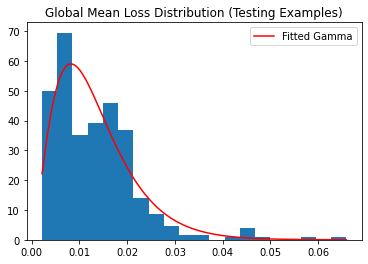

In [10]:
kappa, _, theta = stats.gamma.fit(test_loss, floc=0.)
print(f'Gamma(kappa={kappa:.2f}, theta={theta:.2f})')
gamma_x = np.linspace(np.min(test_loss), np.max(test_loss), 256)
gamma_y = stats.gamma.pdf(gamma_x,a=kappa,scale=theta)
gamma_mean = kappa*theta
gamma_std = np.sqrt(kappa*theta*theta)
print(f'Mean: {gamma_mean:.4}')
print(f'Std. Dev.: {gamma_std:.4}')

test_lossmaps = np.clip(np.array(test_lossmaps),1e-30,None)
test_loss = np.array(test_loss)

plt.figure()
plt.hist(test_loss, bins=20, density=True)
#plt.hist(anomaly_loss, bins=20, density=True)
plt.plot(gamma_x, gamma_y, 'r-', label='Fitted Gamma')
plt.title('Global Mean Loss Distribution (Testing Examples)')
plt.legend()
plt.show()


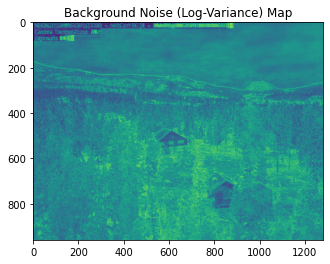

Average kappa: 0.42930862
Average theta 0.038532569443175124


In [11]:
# compute distribution of background noise (by manually fitting to a gamma distribution):
log_lossmaps = np.log(test_lossmaps)
sum_x = np.sum(test_lossmaps, axis=0)
sum_logx = np.sum(log_lossmaps, axis=0)
sum_xlogx = np.sum(test_lossmaps*log_lossmaps, axis=0)
n = test_lossmaps.shape[0]

# use closed form estimators for kappa and theta:
kappa_hat = (n*sum_x) / (n*sum_xlogx - sum_x*sum_logx)
theta_hat = (n*sum_xlogx - sum_x*sum_logx) / (n*n)

variance_map = kappa_hat*theta_hat**2

plt.figure()
plt.imshow(np.log(variance_map))
plt.title('Background Noise (Log-Variance) Map')
plt.show()

print('Average kappa:', np.mean(kappa_hat))
print('Average theta', np.mean(theta_hat))


In [1]:
import matplotlib.patches as patches
import sklearn.preprocessing as preprocessing

def identify_lossmap_boxes(lossmap, kappa_hat, theta_hat, alpha=5e-4, 
                           min_area_frac=0.001, max_n_objs=5):
    im_size = lossmap.shape[0]*lossmap.shape[1]
    gamma_mass = stats.gamma.cdf(lossmap, a=kappa_hat, scale=theta_hat)
    _, thresh_lossmap = cv2.threshold(gamma_mass,(1.0-alpha),1.,cv2.THRESH_BINARY)
    thresh_lossmap = cv2.erode(thresh_lossmap, cv2.getStructuringElement(0, (5,5)))
    thresh_lossmap = cv2.dilate(thresh_lossmap, cv2.getStructuringElement(0, (11,11)))
    thresh_lossmap = thresh_lossmap.astype(np.uint8)

    cnts, _ = cv2.findContours(thresh_lossmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt_list = sorted([
        (cv2.boundingRect(c),cv2.contourArea(c))
        for c in cnts ],
        key= lambda x : -x[1])
    cnts = [ ca[0] for ca in cnt_list if ca[1] > min_area_frac*im_size ]
    cnts = cnts[:min(max_n_objs, len(cnts))]
    
    return thresh_lossmap, cnts

def show_boxes(boxes, ax_ind=0):
    for i, r in enumerate(boxes):
        rect = rect = patches.Rectangle((r[0], r[1]), r[2], r[3], linewidth=1, edgecolor='r', facecolor='none')
        plt.gcf().get_axes()[ax_ind].add_patch(rect)

lossmap_thresh_boxes = [
    identify_lossmap_boxes(lm[0], kappa_hat, theta_hat, max_n_objs=3)
    for lm in anomaly_lossmaps
]


NameError: name 'anomaly_lossmaps' is not defined

In [2]:
fig = plt.figure(figsize=(16,6*(n_anomalies+1)//2))
for i, lmb in enumerate(lossmap_thresh_boxes):
    thresh, box = lmb
    fig.add_subplot((n_anomalies+1)//2,2,i+1)
    plt.imshow(thresh)
    show_boxes(box, i)
    
fig.suptitle('Anomaly Locations',fontsize=24)
#fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(16,6*(n_anomalies+1)//2))
for i, lmb in enumerate(lossmap_thresh_boxes):
    _, box = lmb
    fig.add_subplot((n_anomalies+1)//2,2,i+1)
    plt.imshow(anomaly_examples[i][0])
    show_boxes(box, i)
    
fig.suptitle('Anomaly Locations',fontsize=24)
#fig.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [3]:
from multiprocessing import Pool
alpha_test_values = np.power(10,np.linspace(-8, 0, 32))
n_workers = 6
confusion_matrices = None

def compute_cm(alpha):
        cm = {'TP' : 0, 'FP' : 0, 'TN': 0, 'FN': 0}
        print(f'Computing confusion matrix for alpha={alpha:.3}...')
        for lm in test_lossmaps:
            _, boxes = identify_lossmap_boxes(lm, kappa_hat, theta_hat, alpha=alpha, max_n_objs=1)
            if len(boxes) > 0:
                cm['FP'] += 1
            else:
                cm['TN'] += 1
        for lm_bat in anomaly_lossmaps:
            l, boxes = identify_lossmap_boxes(lm_bat[0], kappa_hat, theta_hat, alpha=alpha, max_n_objs=1)
            if len(boxes) > 0:
                cm['TP'] +=1
            else:
                cm['FN'] += 1
        return cm

# compute confusion matrices:
with Pool(n_workers) as p:
    confusion_matrices = p.map(compute_cm, alpha_test_values)
    

NameError: name 'np' is not defined

In [4]:
def plot_operator_curve(y_func, x_func, cms, 
                        y_name='Y', x_name='X', title='Operator Curve'):
    pts = [ (x_func(cm),y_func(cm)) for cm in cms ]
    pts = np.array([(0,0)] + sorted(pts, key=lambda p : p[0]) + [(1,1)])
    plt.figure()
    plt.title(title)
    plt.plot(pts[:,0],pts[:,1], 'b')
    plt.plot([0,1],[0,1], 'r:')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.plot()
    plt.show()
    
    auc = np.trapz(y=pts[:,1],x=pts[:,0])
    return auc

TPR = lambda cm : cm['TP'] / (cm['TP'] + cm['FN'])
FPR = lambda cm : cm['FP'] / (cm['TN'] + cm['FP'])

auc = plot_operator_curve(TPR,FPR,confusion_matrices,
                          y_name='True Positive Rate',
                          x_name='False Positive Rate',
                          title='ROC Curve Plot')
print(f'Area under ROC Curve: {auc}')


NameError: name 'confusion_matrices' is not defined

In [16]:
# save the model:
save_path = cae.save(f'./models/Attention_CAE_{site_of_interest}')

INFO:tensorflow:Assets written to: ./models/Attention_CAE_NEON.D10.RMNP.DP1.00033/assets


INFO:tensorflow:Assets written to: ./models/Attention_CAE_NEON.D10.RMNP.DP1.00033/assets
